In [213]:
from sympy.printing.pytorch import torch
from ultralytics import YOLO, solutions
import cv2
import os
import numpy as np
import clip
from PIL import  Image
import torch

In [ ]:
model = YOLO('yolo11n.pt')

In [ ]:
def display_objects(video_path, output_video_path):
    cap = cv2.VideoCapture(video_path)
    assert cap.isOpened(), "Error reading video file"
    w, h, fps = (int(cap.get(x)) for x in (cv2.CAP_PROP_FRAME_WIDTH, cv2.CAP_PROP_FRAME_HEIGHT, cv2.CAP_PROP_FPS))
    out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*"mp4v"), fps, (w, h))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        results = model(frame)[0]

        for box in results.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            cls = int(box.cls[0])
            label = model.names[cls]
            conf = box.conf[0]

            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(frame, f'{label} {conf:.2f}', (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 2)

        out.write(frame)

    cap.release()
    out.release()
    cv2.destroyAllWindows()

In [ ]:
def counting_objects_in_regions(video_path, output_video_path):
    cap = cv2.VideoCapture(video_path)
    assert cap.isOpened(), "Error reading video file"
    w, h, fps = (int(cap.get(x)) for x in (cv2.CAP_PROP_FRAME_WIDTH, cv2.CAP_PROP_FRAME_HEIGHT, cv2.CAP_PROP_FPS))
    out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*"mp4v"), fps, (w, h))
    regions = [(500, 300, 900, 900),(1200, 300, 1600, 900)]
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        results = model(frame)[0]
        map_count_in_region = {}
        for index, region in enumerate(regions):
            map_count_in_region[index] = 0
        for box in results.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            cls = int(box.cls[0])
            label = model.names[cls]
            conf = box.conf[0]

            # Tính tâm của bounding box
            cx = (x1 + x2) // 2
            cy = (y1 + y2) // 2

            color = (0, 0, 255)
            # Kiểm tra tâm nằm trong vùng định sẵn
            for index, region in enumerate(regions):
                rx1, ry1, rx2, ry2 = region
                if rx1 <= cx <= rx2 and ry1 <= cy <= ry2:
                    map_count_in_region[index] = map_count_in_region[index] +1
                    color = (0, 255, 0)  # xanh lá nếu nằm trong vùng


            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
            cv2.putText(frame, f'{label} {conf:.2f}', (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

         # Vẽ vùng region
        for index, region in enumerate(regions):
            cv2.rectangle(frame, (region[0], region[1]), (region[2], region[3]), (255, 255, 0), 2)
            cv2.putText(frame, f'Count in region: {map_count_in_region[index]}', (region[0], region[1] - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)
        cv2.putText(frame, 'prompting: Please detect object in my regions', (10, 50),
                        cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 2)
        out.write(frame)

    cap.release()
    out.release()
    cv2.destroyAllWindows()

In [ ]:
counting_objects_in_regions("../resources/video.mp4", "../resources/counting_object_regions.mp4")

In [ ]:
def counting_objects_throw_line(video_path, output_video_path):
    cap = cv2.VideoCapture(video_path)
    assert cap.isOpened(), "Error reading video file"
    w, h, fps = (int(cap.get(x)) for x in (cv2.CAP_PROP_FRAME_WIDTH, cv2.CAP_PROP_FRAME_HEIGHT, cv2.CAP_PROP_FPS))
    out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*"mp4v"), fps, (w, h))
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        results = model(frame)[0]
        for box in results.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            cls = int(box.cls[0])
            label = model.names[cls]
            conf = box.conf[0]

            cy = (y1 + y2) // 2

            color = (0, 0, 255)
            if cy < 300:
                color = (0, 255, 0)


            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
            cv2.putText(frame, f'{label} {conf:.2f}', (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 2)

        cv2.line(frame, (10, 300), (1800, 300), (0, 255, 0), 2)
         # Vẽ vùng region
        out.write(frame)

    cap.release()
    out.release()
    cv2.destroyAllWindows()

In [ ]:
counting_objects_throw_line("../resources/video.mp4", "../resources/counting_object_line.mp4")

In [ ]:
def counting_objects_in_regions_and_crop(video_path, output_video_path):
    cap = cv2.VideoCapture(video_path)
    assert cap.isOpened(), "Error reading video file"
    w, h, fps = (int(cap.get(x)) for x in (cv2.CAP_PROP_FRAME_WIDTH, cv2.CAP_PROP_FRAME_HEIGHT, cv2.CAP_PROP_FPS))
    out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*"mp4v"), fps, (w, h))
    regions = [(500, 300, 900, 900),(1200, 300, 1600, 900)]
    crop_id = 0
    cropped_ids = set()
    crop_dir = "crops"
    os.makedirs(crop_dir, exist_ok=True)
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        results = model.track(frame, persist=True, tracker="bytetrack.yaml")[0]
        # results = model(frame)[0]
        map_count_in_region = {}
        for index, region in enumerate(regions):
            map_count_in_region[index] = 0
        for box in results.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            cls = int(box.cls[0])
            label = model.names[cls]
            conf = box.conf[0]

            # Tracking ID
            if hasattr(box, 'id') and box.id is not None:
                track_id = int(box.id[0])
            else:
                continue  # Skip nếu không có ID

            # Tính tâm của bounding box
            cx = (x1 + x2) // 2
            cy = (y1 + y2) // 2

            color = (0, 0, 255)
            # Kiểm tra tâm nằm trong vùng định sẵn
            for index, region in enumerate(regions):
                rx1, ry1, rx2, ry2 = region
                if rx1 <= cx <= rx2 and ry1 <= cy <= ry2:
                    map_count_in_region[index] = map_count_in_region[index] +1
                    color = (0, 255, 0)  # xanh lá nếu nằm trong vùng
                          # 👉 CROP và LƯU object
                    if track_id not in cropped_ids:
                        obj_crop = frame[y1:y2, x1:x2]
                        crop_path = os.path.join(crop_dir, f"object_{crop_id:04d}_{label}.jpg")
                        cv2.imwrite(crop_path, obj_crop)
                        cropped_ids.add(track_id)
                        crop_id += 1


            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
            cv2.putText(frame, f'{label} {conf:.2f}', (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 2)

         # Vẽ vùng region
        for index, region in enumerate(regions):
            cv2.rectangle(frame, (region[0], region[1]), (region[2], region[3]), (255, 255, 0), 2)
            cv2.putText(frame, f'Count in region: {map_count_in_region[index]}', (region[0], region[1] - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)
        out.write(frame)

    cap.release()
    out.release()
    cv2.destroyAllWindows()

In [ ]:
def counting_objects_in_regions_and_crop_and_blur(video_path, output_video_path):
    cap = cv2.VideoCapture(video_path)
    assert cap.isOpened(), "Error reading video file"
    w, h, fps = (int(cap.get(x)) for x in (cv2.CAP_PROP_FRAME_WIDTH, cv2.CAP_PROP_FRAME_HEIGHT, cv2.CAP_PROP_FPS))
    out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*"mp4v"), fps, (w, h))
    regions = [(500, 300, 900, 900),(1200, 300, 1600, 900)]
    crop_id = 0
    cropped_ids = set()
    crop_dir = "crops"
    os.makedirs(crop_dir, exist_ok=True)
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        results = model.track(frame, persist=True, tracker="bytetrack.yaml")[0]
        # results = model(frame)[0]
        map_count_in_region = {}
        for index, region in enumerate(regions):
            map_count_in_region[index] = 0
        for box in results.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            cls = int(box.cls[0])
            label = model.names[cls]
            conf = box.conf[0]

            # Tracking ID
            if hasattr(box, 'id') and box.id is not None:
                track_id = int(box.id[0])
            else:
                continue  # Skip nếu không có ID

            # Tính tâm của bounding box
            cx = (x1 + x2) // 2
            cy = (y1 + y2) // 2

            color = (0, 0, 255)
            # Kiểm tra tâm nằm trong vùng định sẵn
            for index, region in enumerate(regions):
                rx1, ry1, rx2, ry2 = region
                if rx1 <= cx <= rx2 and ry1 <= cy <= ry2:
                    map_count_in_region[index] = map_count_in_region[index] +1
                    color = (0, 255, 0)  # xanh lá nếu nằm trong vùng
                          # 👉 CROP và LƯU object

                     # ✅ Blur object trong frame
                    object_area = frame[y1:y2, x1:x2]
                    blurred = cv2.GaussianBlur(object_area, (35, 35), 30)
                    frame[y1:y2, x1:x2] = blurred

                    # if track_id not in cropped_ids:
                    #     obj_crop = frame[y1:y2, x1:x2]
                    #     crop_path = os.path.join(crop_dir, f"object_{crop_id:04d}_{label}.jpg")
                    #     cv2.imwrite(crop_path, obj_crop)
                    #     cropped_ids.add(track_id)
                    #     crop_id += 1


            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
            cv2.putText(frame, f'{label} {conf:.2f}', (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 2)

         # Vẽ vùng region
        for index, region in enumerate(regions):
            cv2.rectangle(frame, (region[0], region[1]), (region[2], region[3]), (255, 255, 0), 2)
            cv2.putText(frame, f'Count in region: {map_count_in_region[index]}', (region[0], region[1] - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)
        cv2.putText(frame, 'prompting: Please detect object in my regions and blur it', (10, 50),
                        cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 2)
        out.write(frame)

    cap.release()
    out.release()
    cv2.destroyAllWindows()

In [ ]:
counting_objects_in_regions_and_crop_and_blur("../resources/video.mp4", "../resources/counting_object_regions_blur.mp4")

In [ ]:
def show_objects_heatmap(video_path, output_video_path):
    cap = cv2.VideoCapture(video_path)
    assert cap.isOpened(), "Error reading video file"
    w, h, fps = (int(cap.get(x)) for x in (cv2.CAP_PROP_FRAME_WIDTH, cv2.CAP_PROP_FRAME_HEIGHT, cv2.CAP_PROP_FPS))
    out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*"mp4v"), fps, (w, h))

    # Bản đồ tích lũy điểm nóng
    heatmap_accumulator = np.zeros((h, w), dtype=np.float32)

    # Kernel để tạo hiệu ứng lan tỏa quanh centroid
    kernel = np.zeros((50, 50), np.uint8)
    cv2.circle(kernel, (25, 25), 25, 1, -1)
    ALPHA = 0.7  # độ trong suốt của heatmap overlay
    DECAY = 0.98  # làm mờ dần heatmap theo thời gian
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        results = model(frame)[0]

        for box in results.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            cx = (x1 + x2) // 2
            cy = (y1 + y2) // 2

             # Chồng kernel vào heatmap tại vị trí centroid
            top = max(cy - 25, 0)
            left = max(cx - 25, 0)
            bottom = min(cy + 25, h)
            right = min(cx + 25, w)

            h_k = bottom - top
            w_k = right - left

            heatmap_accumulator[top:bottom, left:right] += kernel[:h_k, :w_k]

        # Làm mờ heatmap qua thời gian
        heatmap_accumulator *= DECAY

        # Normalize và chuyển sang màu
        norm_heatmap = cv2.normalize(heatmap_accumulator, None, 0, 255, cv2.NORM_MINMAX)
        heatmap_color = cv2.applyColorMap(norm_heatmap.astype(np.uint8), cv2.COLORMAP_JET)

         # Overlay heatmap lên frame gốc
        blended = cv2.addWeighted(frame, 1 - ALPHA, heatmap_color, ALPHA, 0)
        out.write(blended)

    cap.release()
    out.release()
    cv2.destroyAllWindows()

In [ ]:
# display_objects("../resources/video.mp4", "output_video.mp4")
counting_objects_in_regions("../resources/video.mp4", "../resources/counting_object_regions.mp4")

In [ ]:
def object_queue_counter(video_path, output_video_path):
    cap = cv2.VideoCapture(video_path)
    assert cap.isOpened(), "Error reading video file"
    w, h, fps = (int(cap.get(x)) for x in (cv2.CAP_PROP_FRAME_WIDTH, cv2.CAP_PROP_FRAME_HEIGHT, cv2.CAP_PROP_FPS))
    out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*"mp4v"), fps, (w, h))
    counter = 0
    box_id_dict = {}
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        results = model.track(frame, persist=True, tracker="bytetrack.yaml")[0]


        for box in results.boxes:

            # Tracking ID
            if hasattr(box, 'id') and box.id is not None:
                track_id = int(box.id[0])
            else:
                continue  # Skip nếu không có ID

            x1, y1, x2, y2 = map(int, box.xyxy[0])
            cls = int(box.cls[0])
            label = model.names[cls]
            conf = box.conf[0]
            if label != "person" or conf < 0.5:
                continue
            if track_id not in box_id_dict:
                box_id_dict[track_id] = counter
                counter += 1

            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(frame, f'#{box_id_dict[track_id]} {conf:.2f}', (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 2)

        out.write(frame)

    cap.release()
    out.release()
    cv2.destroyAllWindows()

In [ ]:
object_queue_counter('../resources/queue_video.mp4', '../resources/queue_video_output.mp4')

In [192]:
def point_in_polygon(x, y, polygon):
    return cv2.pointPolygonTest(np.array(polygon, dtype=np.int32), (x, y), False) >= 0

In [197]:
polygons = [
    [(180, 130), (0, 400), (200, 400),(310, 130)],
    [(310, 130), (180, 470), (400, 470),(480, 130)],
     [(490, 130), (400, 470), (630, 470),(650, 130)],
    [(650, 130), (640, 470), (850, 470),(810, 130)],
    [(810, 130), (860, 470), (1100, 470),(960, 130)],
    [(970, 130), (1100, 470), (1300, 470),(1130, 130)],
]


def parking_slot_detect(video_path, output_video_path):
    cap = cv2.VideoCapture(video_path)
    assert cap.isOpened(), "Error reading video file"
    w, h, fps = (int(cap.get(x)) for x in (cv2.CAP_PROP_FRAME_WIDTH, cv2.CAP_PROP_FRAME_HEIGHT, cv2.CAP_PROP_FPS))
    out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*"mp4v"), fps, (w, h))


    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break



        results = model(frame)[0]

        index_park_dict = {}


        for box in results.boxes:

            x1, y1, x2, y2 = map(int, box.xyxy[0])

            cx = (x1 + x2) // 2
            cy = (y1 + y2) // 2

            # cls = int(box.cls[0])
            # label = model.names[cls]
            # conf = box.conf[0]
            #
            # cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            # cv2.putText(frame, f'{label} {conf:.2f}', (x1, y1 - 10),
            #             cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 2)

            for index, polygon in enumerate(polygons):
                if point_in_polygon(cx, cy, polygon):
                    index_park_dict[index] = True

        for index , polygon in enumerate(polygons):
            color = (0, 255, 0) if index in index_park_dict else (0, 0, 255)
            pts_np = np.array(polygon, dtype=np.int32).reshape((-1, 1, 2))
            cv2.polylines(frame, [pts_np], isClosed=True, color=color, thickness=2)




        out.write(frame)

    cap.release()
    out.release()
    cv2.destroyAllWindows()

In [190]:

# img = cv2.imread("../resources/parking_slot_mask.jpg")
#
#
# Danh sách polygon: mỗi cái là list các (x, y)
# polygons = [
#     [(180, 130), (0, 400), (200, 400),(310, 130)],
#     [(310, 130), (180, 470), (400, 470),(480, 130)],
#      [(490, 130), (400, 470), (630, 470),(650, 130)],
#     [(650, 130), (640, 470), (850, 470),(810, 130)],
#     [(810, 130), (860, 470), (1100, 470),(960, 130)],
#     [(970, 130), (1100, 470), (1300, 470),(1130, 130)],
# ]
#
# Vẽ từng polygon
# for pts in polygons:
#     pts_np = np.array(pts, dtype=np.int32).reshape((-1, 1, 2))
#     cv2.polylines(img, [pts_np], isClosed=True, color=(0, 255, 0), thickness=2)

# # (Tuỳ chọn) vẽ ID vùng
# for i, pts in enumerate(polygons):
#     cx = int(np.mean([p[0] for p in pts]))
#     cy = int(np.mean([p[1] for p in pts]))
#     cv2.putText(img, f"Region {i+1}", (cx - 20, cy),
#                 cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

# Lưu ảnh kết quả
# cv2.imwrite("../resources/parking_slot_mask_output.jpg", img)

True

In [113]:
# video_path = "../resources/parking_slot.mp4"
#
# # Mở video
# cap = cv2.VideoCapture(video_path)
#
# # Lấy frame đầu tiên (frame số 0)
# frame_number = 0
# cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
#
# # Đọc frame
# ret, frame = cap.read()
#
# if ret:
#     # Lưu frame thành ảnh
#     cv2.imwrite("../resources/parking_slot_mask.jpg", frame)
#     print("Đã lưu frame thành công!")
# else:
#     print("Không thể đọc frame từ video.")
#
# cap.release()

Đã lưu frame thành công!


In [198]:
parking_slot_detect('../resources/parking_slot.mp4' , '../resources/parking_slot_output.mp4')


0: 384x640 5 cars, 37.8ms
Speed: 2.0ms preprocess, 37.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 cell phone, 36.9ms
Speed: 1.9ms preprocess, 36.9ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 37.0ms
Speed: 1.7ms preprocess, 37.0ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 1 cell phone, 33.2ms
Speed: 1.3ms preprocess, 33.2ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 cell phone, 34.2ms
Speed: 1.0ms preprocess, 34.2ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 cell phone, 32.5ms
Speed: 1.1ms preprocess, 32.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 37.1ms
Speed: 1.4ms preprocess, 37.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 32.2ms
Speed: 1.1ms preprocess, 32.2ms inference, 0.7ms 

In [295]:
img = cv2.imread('../resources/buying-a-black-car.jpg')

results = model(img)[0]
list_crop = []
for box in results.boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0])
    cls = int(box.cls[0])
    label = model.names[cls]
    conf = box.conf[0]
    print(f"{label} - {conf}")
    list_crop.append(img[int(y1):int(y2), int(x1):int(x2)])


0: 448x640 1 car, 44.4ms
Speed: 2.4ms preprocess, 44.4ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)
car - 0.9150073528289795


In [ ]:
# pip install git+https://github.com/openai/CLIP.git

In [281]:
model_clip, preprocess = clip.load("ViT-B/32", device="cpu")

In [311]:
prompt = "a black car"
text_tokens = torch.cat([clip.tokenize([prompt])]).to("cpu")
text_features = model_clip.encode_text(text_tokens)

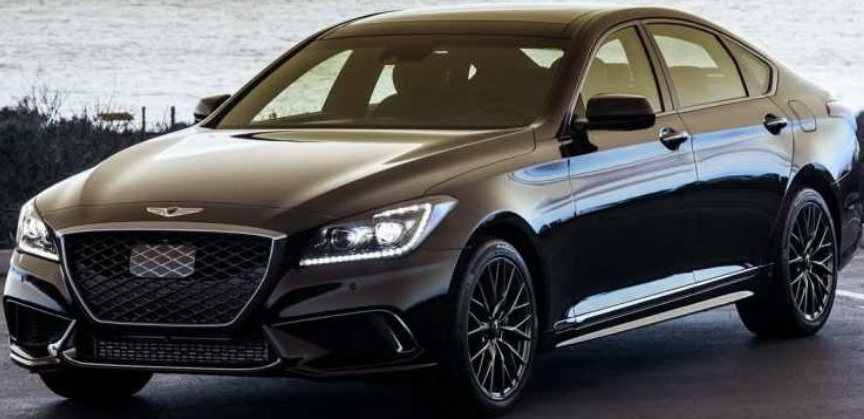

In [312]:
Image.fromarray(list_crop[0])

In [313]:
# Tính độ tương đồng từng crop
similarities = []
for i, crop in enumerate(list_crop):
    img = preprocess(Image.fromarray(crop)).unsqueeze(0).to("cpu")
    image_features = model_clip.encode_image(img)
     # Cosine similarity
    sim = torch.cosine_similarity(image_features, text_features).item()
    similarities.append((i, sim))

In [314]:
similarities

[(0, 0.23752789199352264)]

In [315]:
from ultralytics import solutions

In [320]:
searcher = solutions.VisualAISearch(
    data='../resources',
    device="cpu"  # configure the device for processing i.e "cpu" or "cuda"
)

results = searcher("a black car")


Ultralytics 8.3.141 🚀 Python-3.13.3 torch-2.7.0 CPU (Apple M2)
Loading existing FAISS index...

Ranked Results:
  - parking_slot_mask.jpg | Similarity: 0.2773
  - parking_slot_mask_output.jpg | Similarity: 0.2456
  - buying-a-black-car.jpg | Similarity: 0.2391
  - Screenshot 2025-06-03 at 23.57.15.png | Similarity: 0.2278
  - Copilot_20250603_223730.png | Similarity: 0.2025
  - whiskers_pie.png | Similarity: 0.1839
  - 2025-05-21 10.17.18.jpg | Similarity: 0.1748
  - cat_and_otter_realistic.png | Similarity: 0.1491
  - cat_and_otter.png | Similarity: 0.1481
  - whiskers_king.png | Similarity: 0.1314
  - whiskers_flour.png | Similarity: 0.1291
